In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Data/participants.tsv", sep="\t")
df.head()

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


# Analisi Preliminare del Dataset
 
## Obiettivo
Esplorare le caratteristiche demografiche e cliniche dei pazienti per comprendere:
- Composizione del campione (età, genere, gruppi diagnostici)
- Distribuzione del punteggio MMSE (Mini-Mental State Examination)
- Relazioni tra variabili demografiche e cognitive
- Presenza di outliers o anomalie nei dati
 
## Gruppi di Studio
- **A (AD)**: Alzheimer's Disease - Malattia di Alzheimer
- **F (FTD)**: Frontotemporal Dementia - Demenza Frontotemporale  
- **C (CN)**: Cognitively Normal - Controlli sani


In [3]:
#1. OVERVIEW GENERALE DEL DATASET

def print_dataset_overview(df):
    
    print("-"*60)
    print("PANORAMICA GENERALE DEL DATASET")
    print("-"*60)
    
    print(f"\n DIMENSIONI:")
    print(f"   • Numero pazienti: {df.shape[0]}")
    print(f"   • Numero variabili: {df.shape[1]}")
    
    print(f"\n VARIABILI DISPONIBILI:")
    for i, col in enumerate(df.columns, 1):
        dtype = df[col].dtype
        non_null = df[col].count()
        print(f"   {i:2d}. {col:<15} ({dtype}, {non_null}/{len(df)} valori)")
    
    print(f"\n STATISTICHE DESCRITTIVE:")
    return df.describe(include='all')

stats_overview = print_dataset_overview(df)
stats_overview

------------------------------------------------------------
PANORAMICA GENERALE DEL DATASET
------------------------------------------------------------

 DIMENSIONI:
   • Numero pazienti: 88
   • Numero variabili: 5

 VARIABILI DISPONIBILI:
    1. participant_id  (object, 88/88 valori)
    2. Gender          (object, 88/88 valori)
    3. Age             (int64, 88/88 valori)
    4. Group           (object, 88/88 valori)
    5. MMSE            (int64, 88/88 valori)

 STATISTICHE DESCRITTIVE:


,participant_id,Gender,Age,Group,MMSE
count,88,88,88.000000,88,88.000000
unique,88,2,NaN,3,NaN
top,sub-001,F,NaN,A,NaN
freq,1,44,NaN,36,NaN
mean,NaN,NaN,66.170455,NaN,22.943182
std,NaN,NaN,7.362879,NaN,6.150148
min,NaN,NaN,44.000000,NaN,4.000000
25%,NaN,NaN,61.750000,NaN,20.000000
50%,NaN,NaN,67.000000,NaN,22.000000
75%,NaN,NaN,71.000000,NaN,30.000000


In [5]:
# 2 DATA QUALITY CHECK

def check_data_quality(df):
    print("-"*60)
    print("DATA QUALITY CHECK")
    print("-"*60)
    
    # Missing values
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        print(f"\n⚠️  MISSING VALUES:")
        for col, missing in missing_data[missing_data > 0].items():
            pct = (missing / len(df)) * 100
            print(f"   • {col}: {missing} ({pct:.1f}%)")
    else:
        print(f"\n✅ No missing values detected")
    
    # Specific checks for MMSE (valid range: 0-30)
    mmse_invalid = df[(df['MMSE'] < 0) | (df['MMSE'] > 30)]
    if len(mmse_invalid) > 0:
        print(f"\n⚠️  INVALID MMSE VALUES (0-30):")
        print(mmse_invalid[['participant_id', 'MMSE', 'Group']])
    else:
        print(f"\n✅ All MMSE values are within the valid range (0-30)")
    
    # Age checks
    age_stats = df['Age'].describe()
    print(f"\n AGE RANGE: {age_stats['min']:.0f} - {age_stats['max']:.0f} years")
    
    # Group distribution
    group_dist = df['Group'].value_counts()
    print(f"\n GROUP DISTRIBUTION:")
    for group, count in group_dist.items():
        pct = (count / len(df)) * 100
        group_name = {'A': 'Alzheimer', 'F': 'Frontotemporal', 'C': 'Controls'}[group]
        print(f"   • {group} ({group_name}): {count} patients ({pct:.1f}%)")

check_data_quality(df)


------------------------------------------------------------
DATA QUALITY CHECK
------------------------------------------------------------

✅ No missing values detected

✅ All MMSE values are within the valid range (0-30)

 AGE RANGE: 44 - 79 years

 GROUP DISTRIBUTION:
   • A (Alzheimer): 36 patients (40.9%)
   • C (Controls): 29 patients (33.0%)
   • F (Frontotemporal): 23 patients (26.1%)


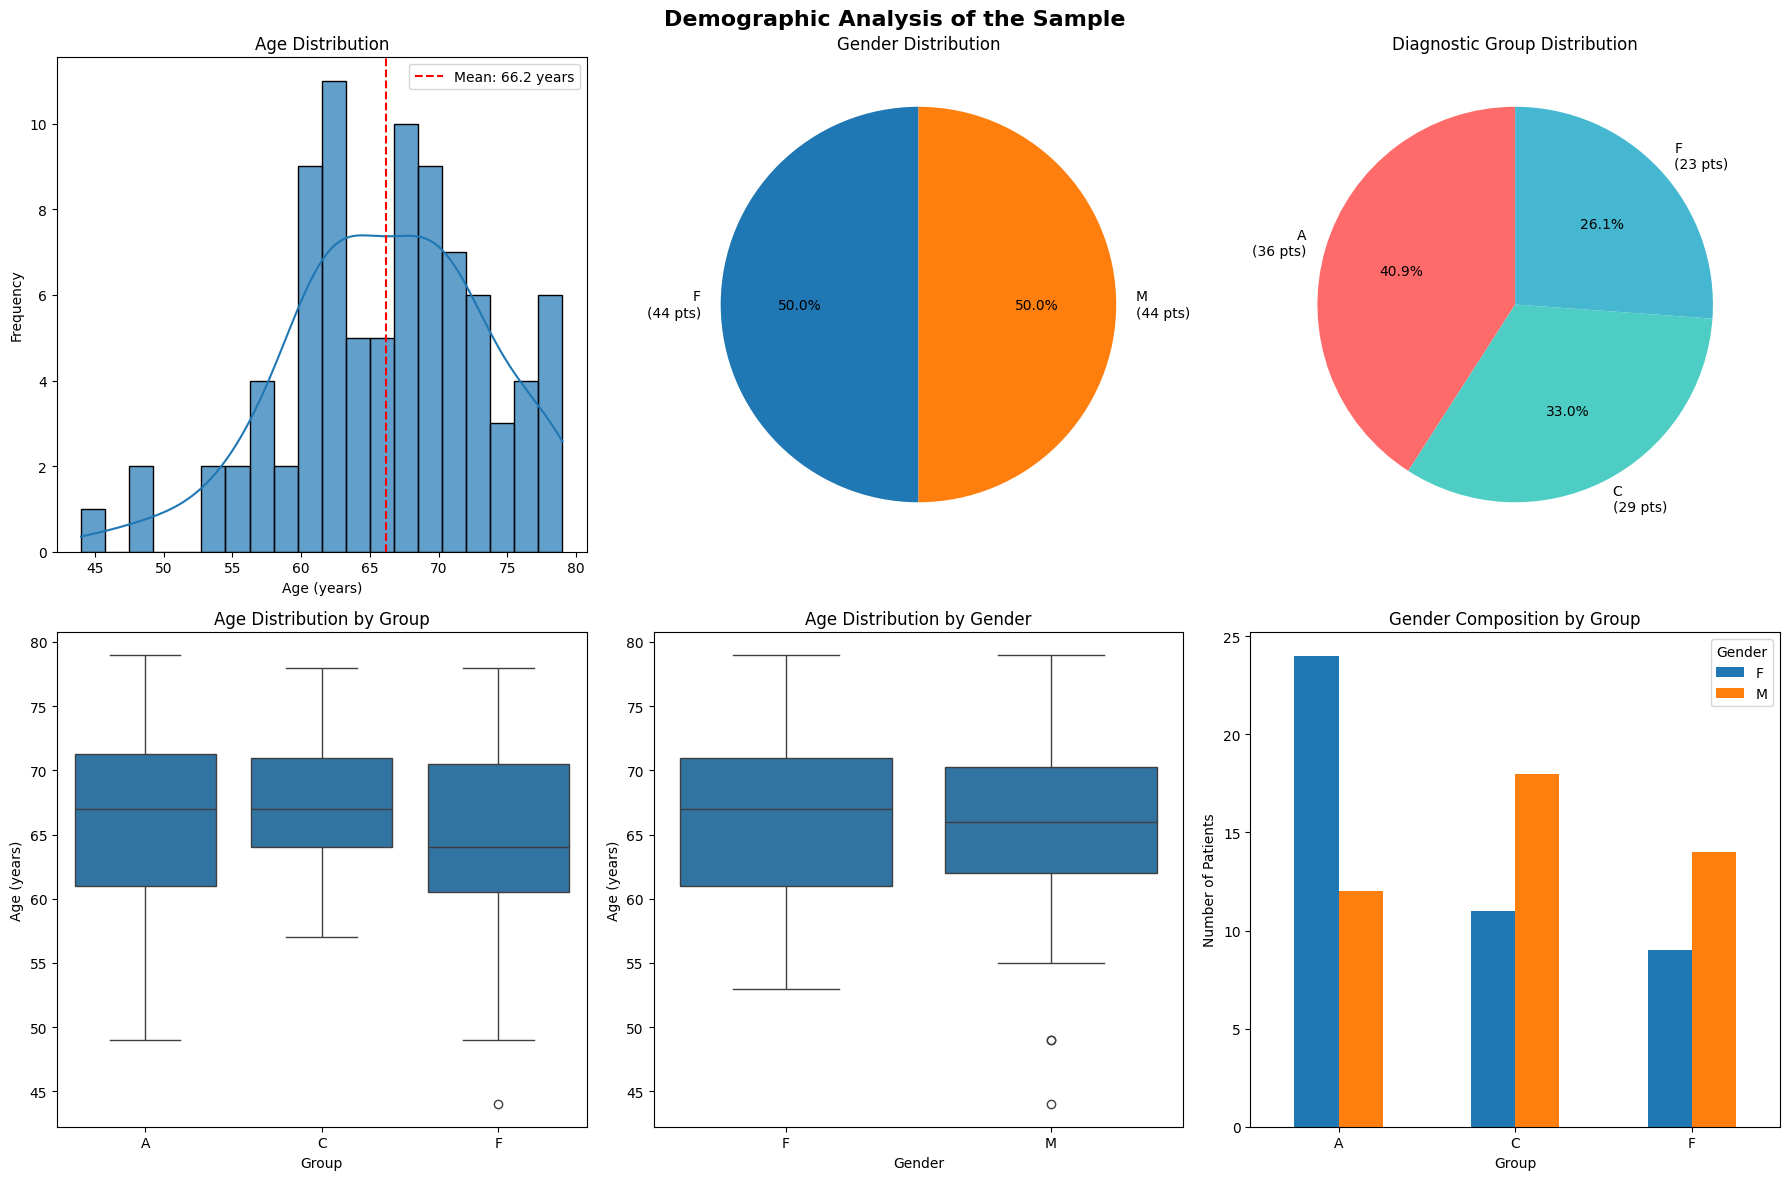

In [6]:
# 3. DETAILED DEMOGRAPHIC ANALYSIS

# Create subplots for demographic analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Demographic Analysis of the Sample', fontsize=16, fontweight='bold')

# 3.1 Age distribution
sns.histplot(data=df, x='Age', bins=20, kde=True, alpha=0.7, ax=axes[0,0])
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["Age"].mean():.1f} years')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age (years)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 3.2 Gender distribution
gender_counts = df['Gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=[f'{idx}\n({count} pts)' for idx, count in gender_counts.items()], 
              autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Gender Distribution')

# 3.3 Diagnostic group distribution
group_counts = df['Group'].value_counts()
group_labels = [f'{idx}\n({count} pts)' for idx, count in group_counts.items()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0,2].pie(group_counts.values, labels=group_labels, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,2].set_title('Diagnostic Group Distribution')

# 3.4 Age by group
sns.boxplot(data=df, x='Group', y='Age', ax=axes[1,0])
axes[1,0].set_title('Age Distribution by Group')
axes[1,0].set_xlabel('Group')
axes[1,0].set_ylabel('Age (years)')

# 3.5 Age by gender
sns.boxplot(data=df, x='Gender', y='Age', ax=axes[1,1])
axes[1,1].set_title('Age Distribution by Gender')
axes[1,1].set_xlabel('Gender')
axes[1,1].set_ylabel('Age (years)')

# 3.6 Age and gender distribution by group
df_pivot = df.groupby(['Group', 'Gender']).size().unstack(fill_value=0)
df_pivot.plot(kind='bar', ax=axes[1,2], rot=0)
axes[1,2].set_title('Gender Composition by Group')
axes[1,2].set_xlabel('Group')
axes[1,2].set_ylabel('Number of Patients')
axes[1,2].legend(title='Gender')

plt.tight_layout()
plt.show()


------------------------------------------------------------
MMSE SCORE ANALYSIS
------------------------------------------------------------

 MMSE STATISTICS BY GROUP:
       count   mean   std  min  max
Group                              
A         36  17.75  4.50    4   23
C         29  30.00  0.00   30   30
F         23  22.17  2.64   18   27

 ANOVA TEST (differences between groups):
   F-statistic: 119.735
   p-value: 1.89e-25
   Interpretation: Significant differences


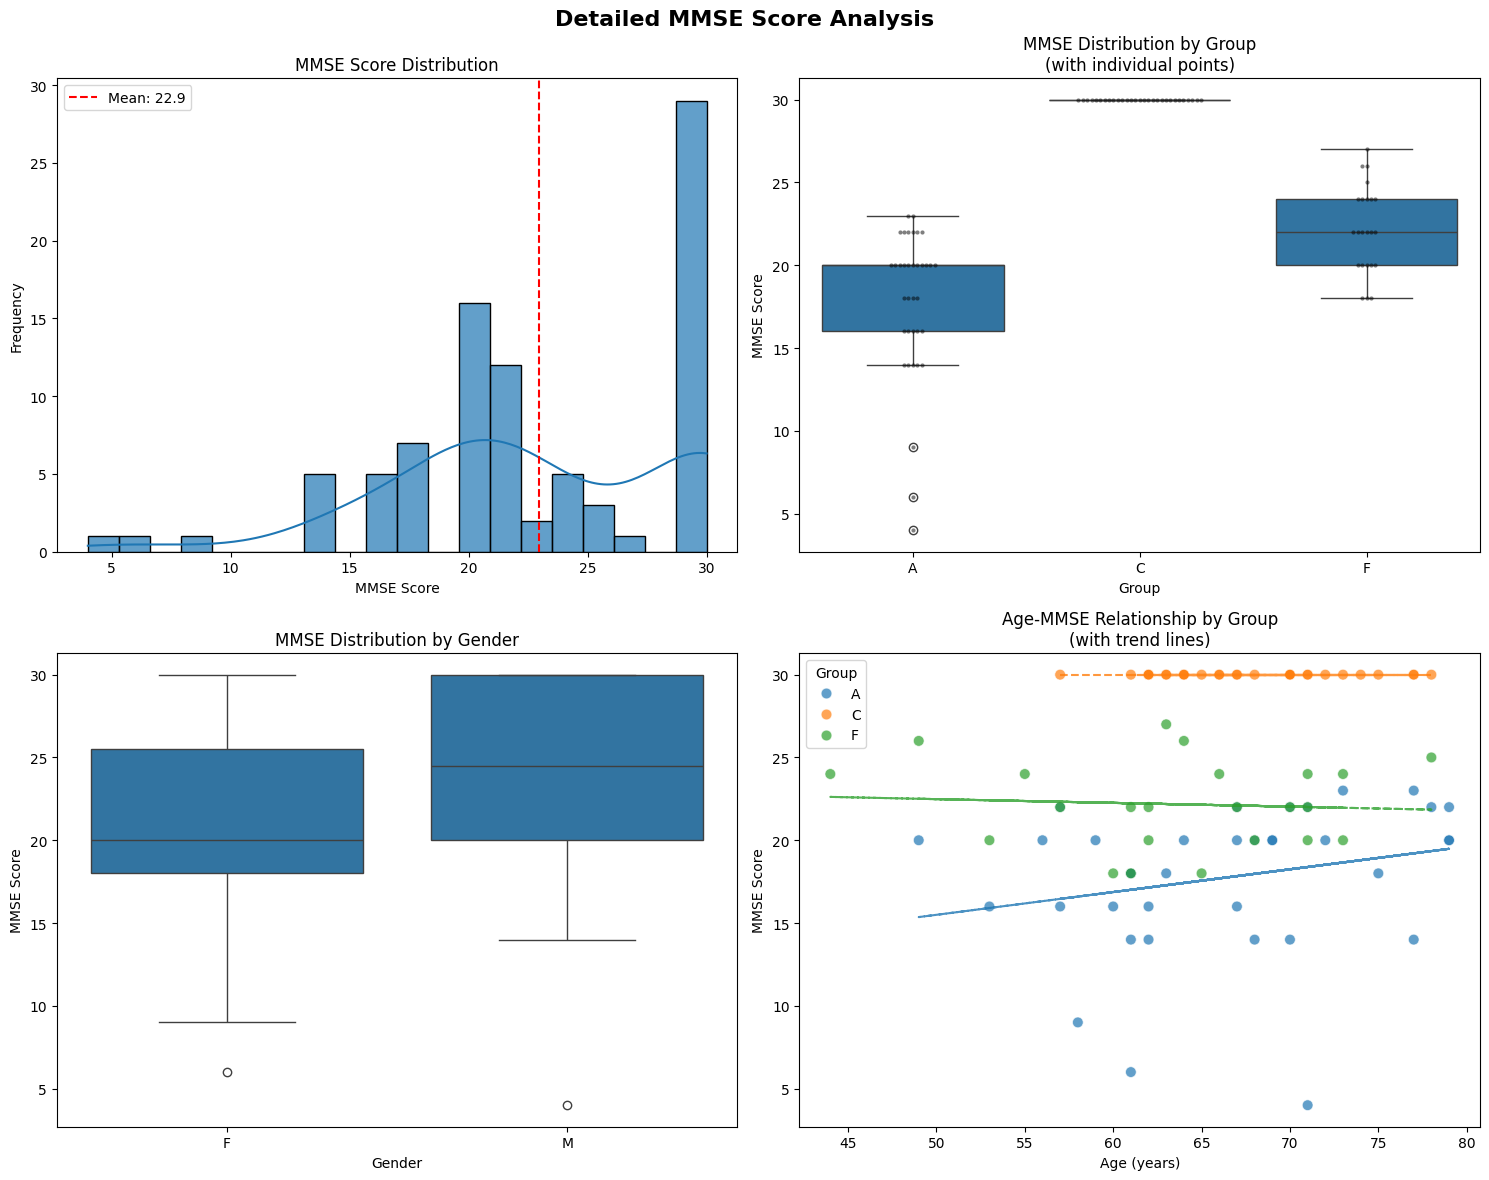

In [7]:
# 4. IN-DEPTH MMSE ANALYSIS

# MMSE statistics by group
print("-"*60)
print("MMSE SCORE ANALYSIS")
print("-"*60)

mmse_stats = df.groupby('Group')['MMSE'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\n MMSE STATISTICS BY GROUP:")
print(mmse_stats)

# ANOVA test for group differences
groups_mmse = [df[df['Group'] == group]['MMSE'] for group in df['Group'].unique()]
f_stat, p_value = stats.f_oneway(*groups_mmse)
print(f"\n ANOVA TEST (differences between groups):")
print(f"   F-statistic: {f_stat:.3f}")
print(f"   p-value: {p_value:.2e}")
print(f"   Interpretation: {'Significant differences' if p_value < 0.05 else 'No significant differences'}")

# MMSE visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed MMSE Score Analysis', fontsize=16, fontweight='bold')

# 4.1 Overall MMSE distribution
sns.histplot(data=df, x='MMSE', bins=20, kde=True, alpha=0.7, ax=axes[0,0])
axes[0,0].axvline(df['MMSE'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["MMSE"].mean():.1f}')
axes[0,0].set_title('MMSE Score Distribution')
axes[0,0].set_xlabel('MMSE Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 4.2 MMSE by group (detailed boxplot)
sns.boxplot(data=df, x='Group', y='MMSE', ax=axes[0,1])
sns.swarmplot(data=df, x='Group', y='MMSE', color='black', alpha=0.5, size=3, ax=axes[0,1])
axes[0,1].set_title('MMSE Distribution by Group\n(with individual points)')
axes[0,1].set_xlabel('Group')
axes[0,1].set_ylabel('MMSE Score')

# 4.3 MMSE by gender
sns.boxplot(data=df, x='Gender', y='MMSE', ax=axes[1,0])
axes[1,0].set_title('MMSE Distribution by Gender')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_ylabel('MMSE Score')

# 4.4 Age-MMSE relationship by group
sns.scatterplot(data=df, x='Age', y='MMSE', hue='Group', alpha=0.7, s=60, ax=axes[1,1])
# Add trend lines
for group in df['Group'].unique():
    subset = df[df['Group'] == group]
    z = np.polyfit(subset['Age'], subset['MMSE'], 1)
    p = np.poly1d(z)
    axes[1,1].plot(subset['Age'], p(subset['Age']), linestyle='--', alpha=0.8)

axes[1,1].set_title('Age-MMSE Relationship by Group\n(with trend lines)')
axes[1,1].set_xlabel('Age (years)')
axes[1,1].set_ylabel('MMSE Score')

plt.tight_layout()
plt.show()


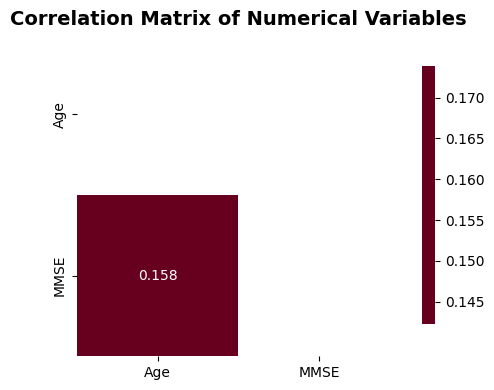


 AGE-MMSE CORRELATION:
   Pearson Correlation Coefficient: 0.158
   p-value: 0.141
   Interpretation: No significant correlation


In [8]:
# 5. CORRELATION AND RELATIONSHIP ANALYSIS
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
            center=0, square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Age-MMSE correlation test
age_mmse_corr, age_mmse_p = stats.pearsonr(df['Age'], df['MMSE'])
print(f"\n AGE-MMSE CORRELATION:")
print(f"   Pearson Correlation Coefficient: {age_mmse_corr:.3f}")
print(f"   p-value: {age_mmse_p:.3f}")
print(f"   Interpretation: {'Significant correlation' if age_mmse_p < 0.05 else 'No significant correlation'}")



 AGE GROUP DISTRIBUTION:
           N_Patients  MMSE_Mean  MMSE_Std Gender_Distribution
Age_Group                                                     
45-55               6      21.67      3.67            M:4, F:2
55-65              34      22.06      6.78          M:17, F:17
65-75              38      23.76      6.13          M:18, F:20
75-85              10      23.60      5.25            M:5, F:5


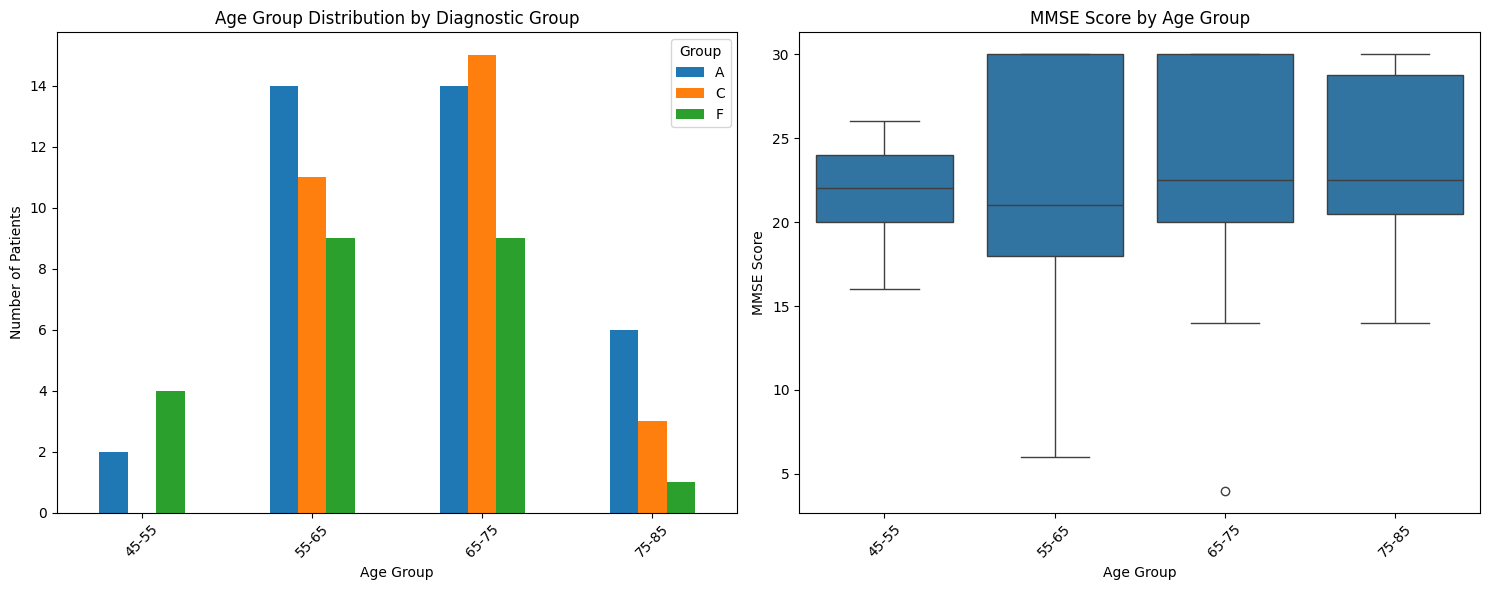

In [9]:
# 6. AGE GROUP ANALYSIS
# Create more informative age groups
age_min, age_max = df['Age'].min(), df['Age'].max()
df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[40, 55, 65, 75, 85], 
                        labels=['45-55', '55-65', '65-75', '75-85'],
                        include_lowest=True)

print(f"\n AGE GROUP DISTRIBUTION:")
age_group_stats = df.groupby('Age_Group').agg({
    'participant_id': 'count',
    'MMSE': ['mean', 'std'],
    'Gender': lambda x: f"M:{sum(x=='M')}, F:{sum(x=='F')}"
}).round(2)

age_group_stats.columns = ['N_Patients', 'MMSE_Mean', 'MMSE_Std', 'Gender_Distribution']
print(age_group_stats)

# Age group visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Age group distribution by diagnostic group
pd.crosstab(df['Age_Group'], df['Group']).plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Age Group Distribution by Diagnostic Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Patients')
axes[0].legend(title='Group')

# MMSE by age group
sns.boxplot(data=df, x='Age_Group', y='MMSE', ax=axes[1])
axes[1].set_title('MMSE Score by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('MMSE Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [10]:
# 7. FINAL STATISTICAL SUMMARY

def generate_summary_report(df):
    """Generate a complete statistical summary"""
    print("="*80)
    print("SUMMARY OF PRELIMINARY ANALYSIS")
    print("="*80)
    
    print(f"\n SAMPLE:")
    print(f"   • Total patients: {len(df)}")
    print(f"   • Mean age: {df['Age'].mean():.1f} ± {df['Age'].std():.1f} years")
    print(f"   • Age range: {df['Age'].min():.0f} - {df['Age'].max():.0f} years")
    
    gender_dist = df['Gender'].value_counts()
    print(f"   • Gender: {gender_dist['M']} males ({gender_dist['M']/len(df)*100:.1f}%), "
          f"{gender_dist['F']} females ({gender_dist['F']/len(df)*100:.1f}%)")
    
    print(f"\n DIAGNOSTIC GROUPS:")
    for group in ['C', 'A', 'F']:
        subset = df[df['Group'] == group]
        group_name = {'C': 'Controls', 'A': 'Alzheimer', 'F': 'Frontotemporal'}[group]
        print(f"   • {group_name}: {len(subset)} patients ({len(subset)/len(df)*100:.1f}%)")
        print(f"     - Age: {subset['Age'].mean():.1f} ± {subset['Age'].std():.1f} years")
        print(f"     - MMSE: {subset['MMSE'].mean():.1f} ± {subset['MMSE'].std():.1f}")
        print(f"     - Gender: M={sum(subset['Gender']=='M')}, F={sum(subset['Gender']=='F')}")
    
    print(f"\n MMSE SCORE:")
    print(f"   • Overall mean: {df['MMSE'].mean():.2f} ± {df['MMSE'].std():.2f}")
    print(f"   • Range: {df['MMSE'].min():.0f} - {df['MMSE'].max():.0f}")
    
    # Statistical tests
    groups_mmse = [df[df['Group'] == group]['MMSE'] for group in df['Group'].unique()]
    f_stat, p_value = stats.f_oneway(*groups_mmse)
    print(f"\n STATISTICAL TESTS:")
    print(f"   • ANOVA MMSE groups: F={f_stat:.2f}, p={p_value:.2e}")
    
    age_mmse_corr, age_mmse_p = stats.pearsonr(df['Age'], df['MMSE'])
    print(f"   • Age-MMSE correlation: r={age_mmse_corr:.3f}, p={age_mmse_p:.3f}")
    
    print(f"\n✅ DATA QUALITY:")
    print(f"   • Missing values: {df.isnull().sum().sum()}")
    print(f"   • MMSE outliers: {len(df[(df['MMSE'] < 0) | (df['MMSE'] > 30)])}")

generate_summary_report(df)


SUMMARY OF PRELIMINARY ANALYSIS

 SAMPLE:
   • Total patients: 88
   • Mean age: 66.2 ± 7.4 years
   • Age range: 44 - 79 years
   • Gender: 44 males (50.0%), 44 females (50.0%)

 DIAGNOSTIC GROUPS:
   • Controls: 29 patients (33.0%)
     - Age: 67.9 ± 5.4 years
     - MMSE: 30.0 ± 0.0
     - Gender: M=18, F=11
   • Alzheimer: 36 patients (40.9%)
     - Age: 66.4 ± 7.9 years
     - MMSE: 17.8 ± 4.5
     - Gender: M=12, F=24
   • Frontotemporal: 23 patients (26.1%)
     - Age: 63.7 ± 8.2 years
     - MMSE: 22.2 ± 2.6
     - Gender: M=14, F=9

 MMSE SCORE:
   • Overall mean: 22.94 ± 6.15
   • Range: 4 - 30

 STATISTICAL TESTS:
   • ANOVA MMSE groups: F=119.74, p=1.89e-25
   • Age-MMSE correlation: r=0.158, p=0.141

✅ DATA QUALITY:
   • Missing values: 0
   • MMSE outliers: 0


## Conclusione

### 1. Sintesi del Dataset

Il dataset analizzato comprende 88 pazienti e 5 variabili clinico-demografiche, rappresentando un campione ben strutturato per lo studio delle demenze.  
La completezza dei dati (100% di valori validi per tutte le variabili) garantisce un’elevata qualità dell’analisi. Il campione è così composto:

- **Età**: il campione presenta un’età media di 66,2 anni (SD = 7,4), con un range compreso tra 44 e 79 anni.  
- **Distribuzione dell’età**: la mediana di 67 anni indica una distribuzione relativamente simmetrica, tipica di studi sulle demenze che coinvolgono prevalentemente popolazioni anziane.  
- **Genere**: il dataset mostra una leggera prevalenza femminile, coerente con l’epidemiologia delle demenze.  
- La distribuzione per quartili (61,8 – 67 – 71 anni) suggerisce una buona rappresentatività delle fasce d’età più a rischio per lo sviluppo di patologie neurodegenerative.

- **Punteggi generali del profilo cognitivo (MMSE)**: media di 22,9 punti (SD = 6,2), indicando un campione misto con diversi gradi di compromissione cognitiva.  
- **Range completo**: 4–30 punti, coprendo l’intero spettro della compromissione cognitiva.  
- **Distribuzione**: la mediana di 22 punti e l’ampia variabilità (SD = 6,2) confermano la presenza di gruppi clinicamente distinti.

### Interpretazione clinica dei punteggi MMSE

- **Controlli sani**: valori attesi > 26  
- **Compromissione lieve**: 20–26 punti  
- **Compromissione moderata-severa**: < 20 punti  



Il dataset risulta di qualità e con validità dei dati, grazie a:

- **Completezza**: assenza totale di valori mancanti  
- **Validità**: tutti i punteggi MMSE rientrano nel range teorico (0–30)  
- **Rappresentatività**: buona distribuzione di età e genere  



### Alcuni dati

Il dataset non presenta valori mancanti e tutti i punteggi MMSE sono compresi nel range valido (0-30).

**Distribuzione gruppi:**
- A (Alzheimer): 36 pazienti (40,9%)
- C (Controlli): 29 pazienti (33,0%)
- F (Frontotemporale): 23 pazienti (26,1%)

La distribuzione dell’età mostra una forma quasi normale, con una leggera asimmetria verso sinistra.  
Il genere è distribuito equamente: 50% femminile e 50% maschile.

Tra i tre gruppi è presente un solo outlier nel gruppo F.  
I boxplot mostrano distribuzioni sovrapposte tra i gruppi.  
Le mediane simili suggeriscono che l’età non rappresenta un fattore confondente rilevante.

